In [1]:
!pip install haystack-ai chroma-haystack

# RAG pipeline with Evaluation.
when evaluating RAG pipeline there are three main types of evaluation:
1. evaluating the retriever
2. evaluating the generator
3. evaluating the system as a whole

## To evaluate the retriever we have different methods given by Haystack:

1. ***ContextRelevanceEvaluator***: uses an LLM to evaluate whether contexts are relevant to a question. It does not require ground truth labels.
4. ***DocumentRecallEvaluator***: evaluates documents retrieved by Haystack pipelines using ground truth labels. It checks how many of the ground truth documents were retrieved. This metric is called recall.
3. ***DocumentMRREvaluator***:
2. ***DocumentMAPEvaluator***:
5. ***DocumentNDCGEvaluator***:

## To evaluate the generator we have different methods given by Haystack:
1. ***FaithfulnessEvaluator***: Uses an LLM to evaluate whether a generated answer can be inferred from the provided contexts. Does not require ground truth labels.
2. ***SASEvaluator***:

RagasEvaluator
DeepEvalEvaluator



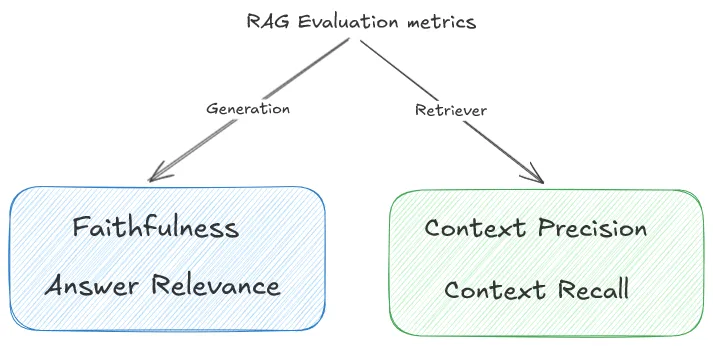

## Evaluation


### installing dataset for evaluation

going to use Arabic Reading Comprehension Dataset (ARCD):


In [2]:
import json

try:
    with open("/content/arcd.json", "r", encoding="utf-8") as f:
        data = json.load(f)
except json.JSONDecodeError as e:
    print(f"JSON Decode Error: {e}")

In [3]:
len(data["data"])

155

In [ ]:
يش

#### the structure if the ARCD dataset
<
file.json<br>
├── "data"<br>
│   └── [i]<br>
│       ├── "paragraphs"<br>
│       │   └── [j]<br>
│       │       ├── "context": "paragraph text"<br>
│       │       └── "qas"<br>
│       │           └── [k]<br>
│       │               ├── "answers"<br>
│       │               │   └── [l]<br>
│       │               │       ├── "answer_start": N<br>
│       │               │       └── "text": "answer"<br>
│       │               ├── "id": "<uuid>"<br>
│       │               └── "question": "paragraph question?"<br>
│       └── "title": "document id"<br>
└── "version": 1.1<br>

let's extract the contexts to files

### building the Pipeline

In [4]:
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.4
    Uninstalling huggingface-hub-0.31.4:
      Successfully uninstalled huggingface-hub-0.31.4


In [5]:
from google.colab import userdata
HF_API_TOKEN = userdata.get('HF_API_TOKEN')
print("okay")

okay


In [6]:
from haystack import component
from haystack import Pipeline, Document
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import HuggingFaceAPIDocumentEmbedder
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.utils import Secret

In [ ]:
document_store = ChromaDocumentStore(collection_name='arcd_evaluation', embedding_function='default', persist_path='/content/vectordb')


In [7]:
document_store_inMemory = InMemoryDocumentStore(embedding_similarity_function="cosine")


indexing pipeline

In [79]:
import os
import json
import re

from typing import List, Dict, Any

def sanitize_name(name: str) -> str:
    return re.sub(r'[<>:"/\\|?*\x00-\x1F]', '_', name)

@component
class ArcdJsonInjestor:

    @classmethod
    def validate(cls, input_file: str):
        if not os.path.exists(input_file):
            raise ValueError(f"File '{input_file}' does not exist.")

    @component.output_types(documents=List[Document], qacs=List[Dict[str, Any]])
    def run(self, input_file: str):
        documents = []
        questions = []

        with open(input_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        for doc_data in data.get("data", []):
            title = doc_data.get("title", "untitled")
            sanitized_title = sanitize_name(title)

            for para in doc_data.get("paragraphs", []):
                context = para.get("context", "").strip()
                # Create Document object
                doc = Document(
                    content=context,
                    meta={"title": sanitized_title}
                )
                documents.append(doc)

                # Process associated questions
                para_questions = para.get("qas", [])
                for qas in para_questions:
                    questions.append({
                        "question": qas.get("question", ""),
                        "ground_truth_context": doc,
                        "ground_truth_answer": qas.get('answers')[0].get('text')
                    })

        output = {
            "documents": documents,
            "qacs": questions
        }
        return output

In [80]:
pipeline = Pipeline()
pipeline.add_component('injestor', ArcdJsonInjestor())
# pipeline.add_component('cleaner', DocumentCleaner(remove_empty_lines=True, remove_extra_whitespaces=True, remove_repeated_substrings=False))
pipeline.add_component('embedder',SentenceTransformersDocumentEmbedder(model="mhaseeb1604/bge-m3-law",token=Secret.from_token(HF_API_TOKEN)))
# pipeline.add_component('splitter', DocumentSplitter(split_by='sentence', split_length=3, split_overlap=1))
pipeline.add_component('writer', DocumentWriter(document_store=document_store_inMemory, policy=DuplicatePolicy.SKIP))

# pipeline.connect('injestor.documents', 'cleaner.documents')
# pipeline.connect('cleaner.documents', 'splitter.documents')
pipeline.connect('injestor.documents', 'embedder.documents') ## do cleaning for both outputs of injestor.
pipeline.connect('embedder.documents', 'writer.documents')



🚅 Components
  - injestor: ArcdJsonInjestor
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - injestor.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

In [81]:
# Run pipeline
indexing_results = pipeline.run({
    'injestor': {'input_file': '/content/arcd.json'},
}, include_outputs_from = {"injestor"})

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.dataclasses import ChatMessage
from haystack.utils import Secret
from haystack.components.generators.chat import HuggingFaceAPIChatGenerator, HuggingFaceLocalChatGenerator
from haystack.components.generators import HuggingFaceLocalGenerator
from haystack.components.routers import ConditionalRouter
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack.components.retrievers import InMemoryEmbeddingRetriever

from haystack import component
from haystack.components.embedders import SentenceTransformersTextEmbedder


In [12]:
system_prompt = """you are arabic virtual assistant, you answer user queries in arabic."""

main_prompt_template =system_prompt +  """
ROLE AND CONTEXT:
You are a knowledgeable assistant. Your task is to provide accurate and detailed answers to queries. Use the provided excerpts and references from useful resources to support your answers.

INSTRUCTIONS:
1. Identify the relevant sections of the excerpts provided.
2. Provide a concise and informative response.
3. Ensure your responses are clear and easy to understand.

EXCERPTS:
{% for doc in documents %}
    excerpt: {{ doc.content }}
{% endfor %}

CONSIDERATIONS:
- If the query cannot be answered given the provided documents, return 'no_answer'

Query: {{query}}
Answer:
"""

fallback_prompt_template = system_prompt + """
User entered a query that cannot be answered with the excerpts provided.
The query was: {{query}}.
Let the user know why the question cannot be answered. Be brief.
"""

In [13]:
model_name='CohereLabs/c4ai-command-r7b-arabic-02-2025'


In [90]:
query_embedder = SentenceTransformersTextEmbedder(model="mhaseeb1604/bge-m3-law",token=Secret.from_token(HF_API_TOKEN))
retriever = InMemoryEmbeddingRetriever(document_store = document_store_inMemory, top_k=5)
# retriever = ChromaQueryTextRetriever(document_store=document_store, top_k=5)
template1 = [ChatMessage.from_user(main_prompt_template)]
main_promptbuilder = ChatPromptBuilder(template=template1)
template2 = [ChatMessage.from_user(fallback_prompt_template)]
fallback_promptbuilder = ChatPromptBuilder(template=template2)
# main_llm = HuggingFaceLocalChatGenerator(model="silma-ai/SILMA-Kashif-2B-Instruct-v1.0")
main_llm = HuggingFaceLocalChatGenerator(model="Qwen/Qwen2.5-1.5B-Instruct")
# main_llm = HuggingFaceLocalChatGenerator(model="Qwen/Qwen2-1.5B-Instruct")
# main_llm = HuggingFaceLocalChatGenerator(model="google/gemma-2-2b-it")

fallback_llm = HuggingFaceAPIChatGenerator(
    api_type="serverless_inference_api",
    api_params={"model": model_name},
    token=Secret.from_token(HF_API_TOKEN))

@component
class ChatMessageToTextConverter:
    @component.output_types(replies_text=list[str])
    def run(self, replies: list[ChatMessage], **kwargs):
        # replies: list of ChatMessage objects
        texts = [msg.text for msg in replies]
        return {"replies_text": texts}

conditional_router = ConditionalRouter([
    {
        "condition": "{{'no_answer' not in replies[0].text }}",
        "output": "{{replies}}",
        "output_name": "replies",
        "output_type": list[str],
    },
    {
        "condition": "{{'no_answer' in replies[0].text }}",
        "output": "{{query}}",
        "output_name": "go_to_fallback",
        "output_type": str,
    },
])

In [91]:
# Setup pipeline
pipeline = Pipeline()
pipeline.add_component('embedder', query_embedder)
pipeline.add_component('retriever', retriever)
pipeline.add_component('main_promptbuilder', main_promptbuilder)
pipeline.add_component('fallback_promptbuilder', fallback_promptbuilder)
pipeline.add_component('main_llm', main_llm)
pipeline.add_component('fallback_llm', fallback_llm)
pipeline.add_component('conditional_router', conditional_router)
pipeline.add_component('converter',ChatMessageToTextConverter())

pipeline.connect('embedder.embedding', 'retriever.query_embedding')
pipeline.connect('retriever.documents', 'main_promptbuilder.documents')
pipeline.connect('main_promptbuilder.prompt', 'main_llm.messages')

pipeline.connect('main_llm.replies', 'converter.replies')
pipeline.connect('converter.replies_text', 'conditional_router.replies')

pipeline.connect('conditional_router.go_to_fallback', 'fallback_promptbuilder.query')
pipeline.connect('fallback_promptbuilder.prompt', 'fallback_llm.messages')

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - main_promptbuilder: ChatPromptBuilder
  - fallback_promptbuilder: ChatPromptBuilder
  - main_llm: HuggingFaceLocalChatGenerator
  - fallback_llm: HuggingFaceAPIChatGenerator
  - conditional_router: ConditionalRouter
  - converter: ChatMessageToTextConverter
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> main_promptbuilder.documents (List[Document])
  - main_promptbuilder.prompt -> main_llm.messages (List[ChatMessage])
  - fallback_promptbuilder.prompt -> fallback_llm.messages (List[ChatMessage])
  - main_llm.replies -> converter.replies (List[ChatMessage])
  - conditional_router.go_to_fallback -> fallback_promptbuilder.query (str)
  - converter.replies_text -> conditional_router.replies (list[str])

In [92]:
import random  # Added for shuffling

def run(question: str):
  results = pipeline.run({
      'embedder': {'text': q},
      'main_promptbuilder': {'query': q},
      'conditional_router': {'query': q},
  }, include_outputs_from={'retriever'})
  return results

def get_context(results):
  retriever_output = results["retriever"]['documents']
  return retriever_output


def get_reply(results):
  response = results.get('conditional_router') or results.get('fallback_llm')
  reply = response['replies'][0].replace('\n', '')
  return reply

def get_qacs_lists(qacs, limit=-1) -> dict:
    random.shuffle(qacs)
    questions=[]
    contexts=[]
    answers=[]
    for idx, qac in enumerate(qacs):
      if idx >= limit and limit != -1:
        break
      questions.append(qac.get('question'))
      contexts.append(qac.get('ground_truth_context'))
      answers.append(qac.get('ground_truth_answer'))

    return {"questions":questions, "ground_truth_answers":answers, "ground_truth_contexts":contexts}

`Next step build evaluation pipeline`

In [93]:
qacs = get_qacs_lists(indexing_results['injestor']['qacs'], 100)
print(len(qacs['questions']))


100


In [94]:
!pip install tqdm
from tqdm.notebook import tqdm

In [95]:
predicted_data = []
for q in tqdm(qacs['questions'], desc="running: "):
  results = run(q)
  predicted_context = get_context(results)
  predicted_answer = get_reply(results)
  predicted_data.append({ "predicted_answer":predicted_answer, "predicted_context":predicted_context})


running:   0%|          | 0/100 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [118]:
predicted_data[0]
predicted_data[0].keys()

dict_keys(['predicted_answer', 'predicted_context'])

`save results to json just in case!`

### Evaluation Pipeline

In [100]:
from haystack.components.evaluators import DocumentMRREvaluator, DocumentRecallEvaluator
from haystack.components.evaluators.faithfulness import FaithfulnessEvaluator
from haystack.components.evaluators.sas_evaluator import SASEvaluator

eval_pipeline = Pipeline()
eval_pipeline.add_component("recall_evaluator", DocumentRecallEvaluator())
# eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator())
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="sentence-transformers/all-MiniLM-L6-v2"))

In [110]:
ground_truth_docs = [[cd] for cd in qacs['ground_truth_contexts']]
retrieved_docs = [item['predicted_context']['documents'] for item in predicted_data]
ground_truth_answers = [answer for answer in qacs['ground_truth_answers']]
rag_answers = [item['predicted_answer'] for item in predicted_data]
questions = [question for question in qacs['questions']]

In [112]:
print(len(ground_truth_docs))
print(len(ground_truth_docs[0]))
print(len(retrieved_docs))
print(len(retrieved_docs[0]))

100
1
100
5


In [113]:
eval_results = eval_pipeline.run(
    {
        "recall_evaluator": {
            "ground_truth_documents": list(ground_truth_docs),
            "retrieved_documents": list(retrieved_docs),
        },
        "sas_evaluator": {"predicted_answers": rag_answers, "ground_truth_answers": list(ground_truth_answers)},
    }
)

In [114]:
from haystack.evaluation.eval_run_result import EvaluationRunResult

inputs = {
    "question": list(questions),
    "contexts": list(ground_truth_docs),
    "answer": list(ground_truth_answers),
    "predicted_answer": rag_answers,
}

evaluation_result = EvaluationRunResult(run_name="pubmed_rag_pipeline", inputs=inputs, results=eval_results)
evaluation_result.aggregated_report()

{'metrics': ['recall_evaluator', 'sas_evaluator'],
 'score': [0.89, np.float64(0.5127101690322161)]}